<a id='startpage'></a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.sample(3))
df.info()

,num_orders
datetime,
2018-07-26 16:00:00,26
2018-05-14 22:20:00,14
2018-04-30 01:50:00,11


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Нулевых значений и пропусков нет.

Проверим индекс на монотонность.

In [4]:
df.index.is_monotonic

True

## Анализ

Сделаем ресемплирование по одному часу.

In [5]:
data = df.resample('1H').sum()

### Стационарность

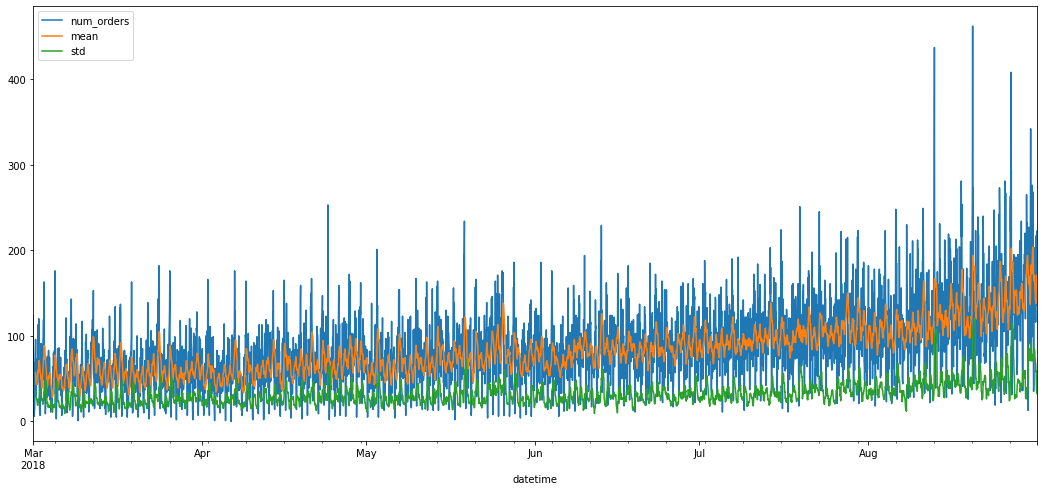

In [6]:
# сглаживание по дням
data['mean'] = data['num_orders'].rolling(12).mean() 
data['std'] = data['num_orders'].rolling(12).std()
data.plot(figsize=(18, 8)); 

Для нашего ряда заметен тренд в сторону повышения значений, начиная с июля. Но, если сгладить по неделям, то можно увидеть более общую динамику изменений.

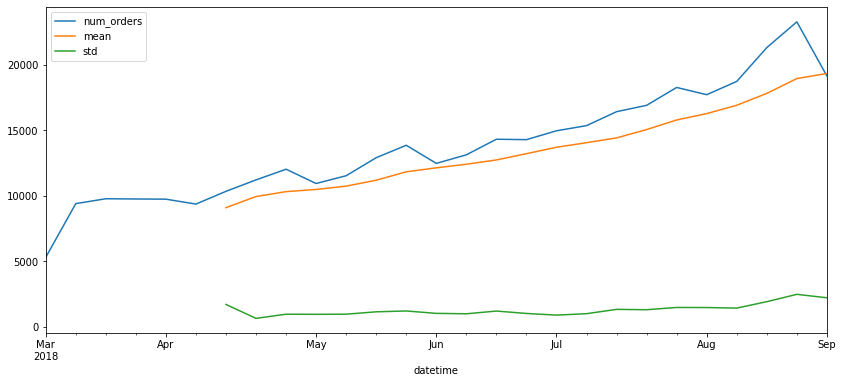

In [7]:
data_week = df.resample('1W').sum()
data_week['mean'] = data_week['num_orders'].rolling(7).mean()
data_week['std'] = data_week['num_orders'].rolling(7).std()
data_week.plot(figsize=(14, 6));

Визуально наш ряд не стационарен: скользящее среднее отклонение со временем практически не изменяется, однако, среднее значение имеет тренд.

Проверим стационарность тестом Дики-Фуллера.

In [8]:
# Функция проверки ряда тестом Дики-Фуллера на стационарность
def adf(series):
  p_value = ts.adfuller(series)[1]
  print(f"p-value = {p_value}")
  if p_value > 0.05:
    print('Ряд не стационарный')
  else:
    print('Ряд стационарный')
    
adf(data['num_orders'])

p-value = 0.028940051402612906
Ряд стационарный


Проверка на ряде данных `data`, ресемплированном по часам, показала, что наш ряд стационарный.
Сделаем проверку на `data_week`.

In [9]:
adf(data_week['num_orders'])

p-value = 0.9990561132668951
Ряд не стационарный


Исходный ряд стационарным не является.

При подаче на проверку стационарности сгруппированных данных `data_week`, результат теста отличается от проверки на данных более низкой размерности. 
Отметим, что полезно группировать данные до более высоких порядков при определении стационарности ряда.

Заметим также, что большинство моделей для прогнозирования предполагают стационарность ряда, следовательно, для более лучшего прогнозирования данные следует преобразовать, чтоб получить стационарный ряд: дифференцирование и т.п.

### Разложение временного ряда на тренд, сезонность и остаток

Разложим временной ряд на:
* `decomposed_trend`-тренд, 
* `decomposed_seasonal`-сезонность,
* `decomposed_resid`-остаток.

In [10]:
data = data.drop(['mean','std'], axis=1)
decomposed = seasonal_decompose(data)

#### Тренд

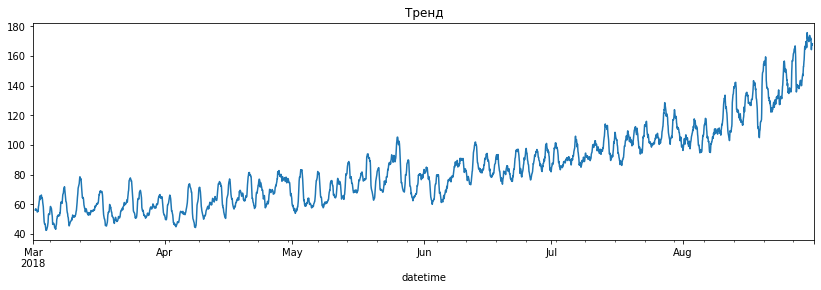

In [11]:
decomposed.trend.plot(figsize=(14, 4))
plt.title('Тренд')
plt.show()

**Вывод** : В период с марта по конец августа наблюдается плавное увеличение количества заказов такси, а в период с июля по конец августа - более резкое возрастание.

#### Сезонная составляющая

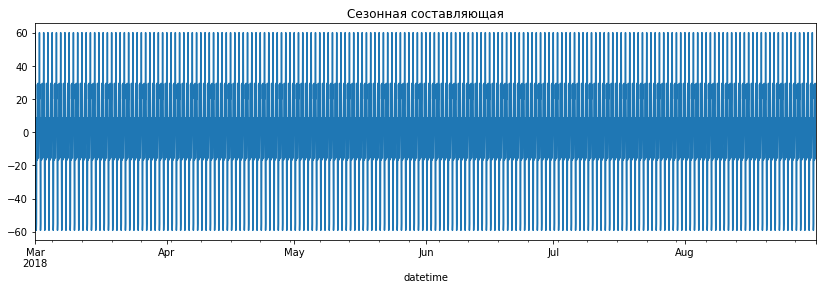

In [13]:
decomposed.seasonal.plot(figsize=(14, 4))
plt.title('Сезонная составляющая')
plt.show()

Посмотрим на ряд в масштабе нескольких дней и месяца.

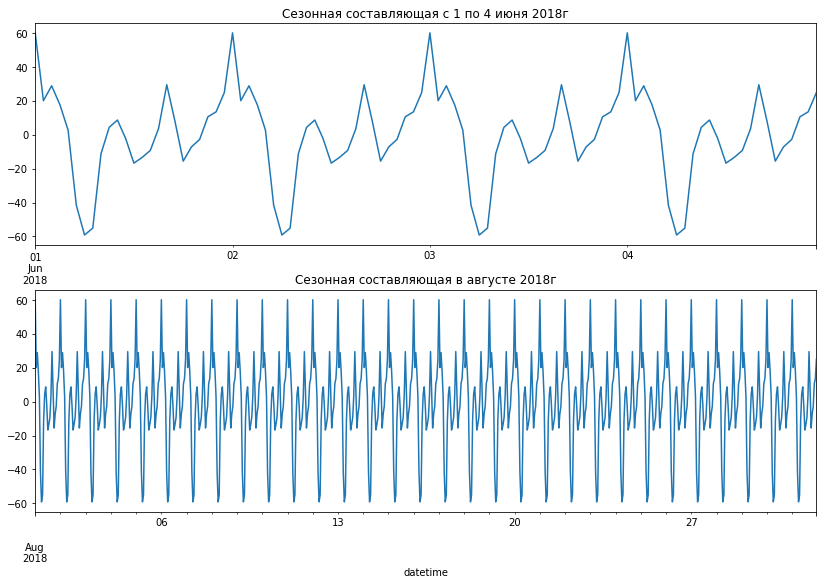

In [14]:
plt.figure(figsize=(14, 9))
plt.subplot(211)
decomposed.seasonal['2018-06-01':'2018-06-04'].plot(ax=plt.gca())
plt.title('Сезонная составляющая с 1 по 4 июня 2018г')
plt.subplot(212)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонная составляющая в августе 2018г')
plt.show()

На диаграммах мы наблюдаем ежедневную сезонность ряда.

##### Автокорреляция

Посмотрим на сезонность через автокорреляцию.

Построим график автокорреляции (двухмерный график, демонстрирующий корреляцию между двумя временными рядами – исходным и сдвинутым на один час назад).

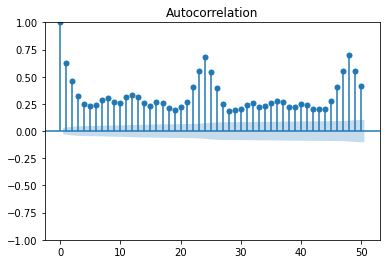

In [18]:
avtocorr = plot_acf(data['num_orders'], lags=50)
plt.show()

Пик, приходящийся на значение 24(48), говорит о том, что при сдвиге ряда на 24 значения у нас резко возрастает корреляция ряда самим с собой, что означает наличие суточной сезонности. Учтем это при подборе признаков (лага).

Частичная автокорреляция (Partial Autocorrelation) — это краткая характеристика взаимосвязи между Наблюдением (Observation) во Временном ряду (Time Series) и наблюдениями на предыдущем отрезке времени с удалением взаимосвязей между промежуточными наблюдениями.

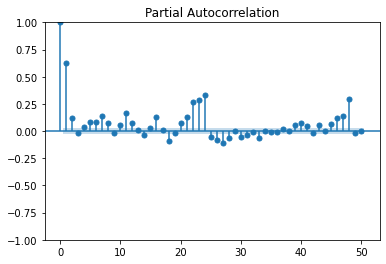

In [19]:
plot_pacf(data['num_orders'], lags=50)
plt.show()

Посмотрим на корреляцию данных, ресемплированных по дню.

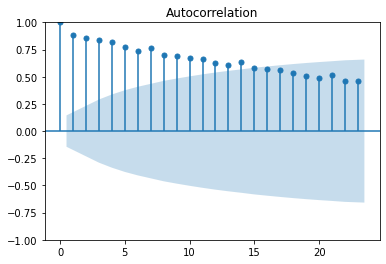

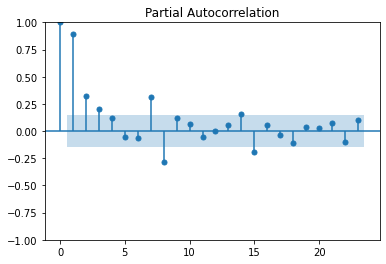

In [20]:
data_day = df.resample('1D').sum()
avtocorr_day = plot_acf(data_day['num_orders'])
plot_pacf(data_day['num_orders'])
plt.show()

Здесь мы видим небольшие пики, кратные 7, то есть наблюдается и недельная сезонность.

#### Остаток декомпозиции

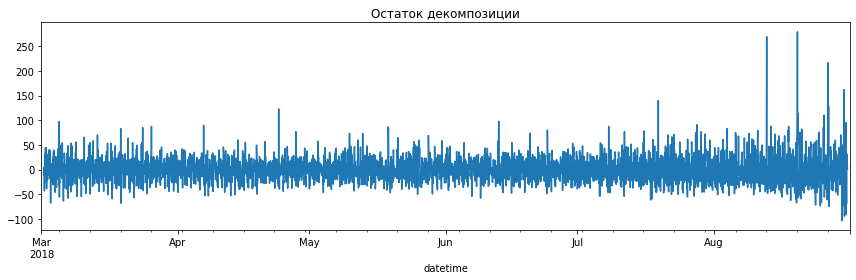

In [21]:
decomposed.resid.plot(figsize=(12, 4))
plt.title('Остаток декомпозиции')
plt.tight_layout()
plt.show()

Значения остатка указывают на количество шума в данных. Значения, близкие к нулю, говорят о том, что сезонный и трендовый компоненты являются точными описаниями временных рядов, а большие значения говорят о том, что в данных присутствует шум.

В мае мы наблюдаем уменьшение шума в данных, а в августе остаток декомпозиции выше.

### Приведение ряда к стационарности

Вычислим разности временного ряда для того, чтоб сделать ряд более стационарным.

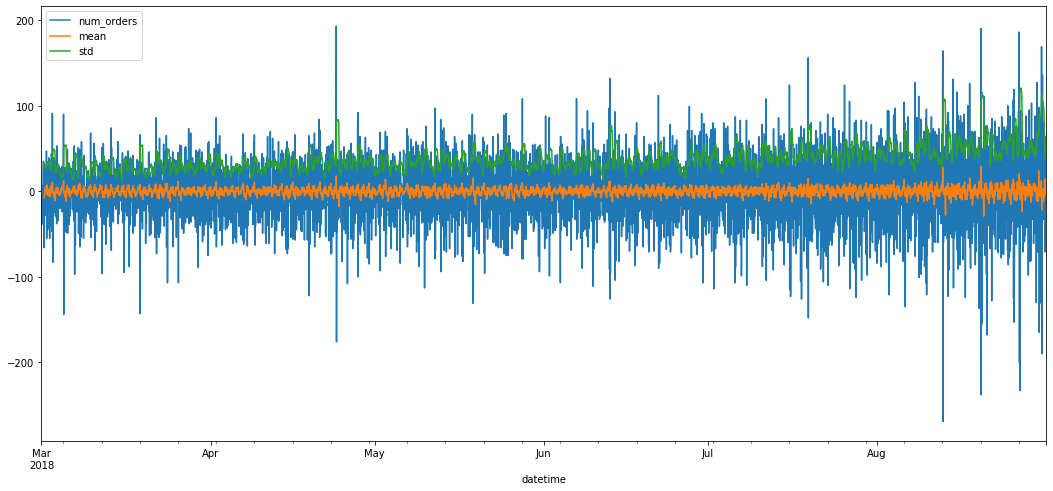

In [22]:
data_new = data - data.shift()
data_new['mean'] = data_new['num_orders'].rolling(12).mean()
data_new['std'] = data_new['num_orders'].rolling(12).std()
data_new.plot(figsize=(18, 8)); 

Проверим наш ряд на стационарность.

In [23]:
data_week_new = data_new.resample('1W').sum()
adf(data_week_new['num_orders'])

p-value = 2.130609617424791e-18
Ряд стационарный


### Создание признаков

Мы выявили тренд по месяцам и закономерности ряда от недели, дня и часа. Создадим календарные признаки и лаги. Напишем функцию. 

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [25]:
data_new = data_new.drop(['mean', 'std'], axis=1)
make_features(data_new, 1, 24)
data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4415 non-null   float64
 1   month         4416 non-null   int64  
 2   dayofweek     4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   hour          4416 non-null   int64  
 5   lag_1         4414 non-null   float64
 6   rolling_mean  4391 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 276.0 KB


### Деление на обучающую и тестовую выборки

Разобьем данные на обучающую и тестовую выборки. Убедимся в корректности деления.

In [26]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [27]:
train = train.dropna()
print(train.shape)
print(test.shape)

(3949, 7)
(442, 7)


In [28]:
features_train = train.drop(['num_orders'], axis=1) # Переменные для обучающей выборки
target_train = train['num_orders']
print(features_train.shape, target_train.shape)

features_test = test.drop(['num_orders'], axis=1) # Переменные для тестовой выборки
target_test = test['num_orders']
print(features_test.shape, target_test.shape)

(3949, 6) (3949,)
(442, 6) (442,)


## Обучение моделей

### LinearRegression

In [29]:
%%time
# Создадим параметры для модели LinearRegression
param_grid_lg = {
    'normalize': [True, False]
}

lg = LinearRegression()
tscv = TimeSeriesSplit(n_splits=8)

grid_search_lg = GridSearchCV(estimator=lg, param_grid=param_grid_lg, scoring='neg_root_mean_squared_error', 
                              cv=tscv, n_jobs=-1, verbose=2)

grid_search_lg.fit(features_train, target_train)

print("RMSE лучшей модели LinearRegression:", abs(grid_search_lg.best_score_).round(4),
      "\nЛучшая модель:", grid_search_lg.best_params_)

Fitting 8 folds for each of 2 candidates, totalling 16 fits
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................norm

RMSE лучшей модели LinearRegression: 33.5454

Лучшая модель: {'normalize': True}

CPU times: user 153 ms, sys: 56.1 ms, total: 209 ms

Wall time: 191 ms

### LGBMRegressor

In [30]:
%%time

param_lgbm = {
    'num_leaves': [30, 50, 70], 
    'learning_rate': [0.1, 0.3]
}

lgbm = LGBMRegressor(random_state=12345) 

rand_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_lgbm, scoring='neg_root_mean_squared_error',
                                cv=tscv, n_jobs=-1, verbose=2, n_iter = 2)
rand_search_lgbm.fit(features_train, target_train)

print("RMSE лучшей модели LGBMRegressor:", abs(rand_search_lgbm.best_score_).round(4),
      "\nЛучшая модель:", rand_search_lgbm.best_params_)

Fitting 8 folds for each of 2 candidates, totalling 16 fits
[CV] END ...................learning_rate=0.1, num_leaves=30; total time=  56.6s
[CV] END ...................learning_rate=0.1, num_leaves=30; total time=  34.4s
[CV] END ...................learning_rate=0.1, num_leaves=30; total time= 1.1min
[CV] END ...................learning_rate=0.1, num_leaves=30; total time=  45.8s
[CV] END ...................learning_rate=0.1, num_leaves=30; total time=  57.4s
[CV] END ...................learning_rate=0.1, num_leaves=30; total time=  17.1s
[CV] END ...................learning_rate=0.1, num_leaves=30; total time=  11.9s
[CV] END ...................learning_rate=0.1, num_leaves=30; total time=   5.6s
[CV] END ...................learning_rate=0.1, num_leaves=70; total time=  51.7s
[CV] END ...................learning_rate=0.1, num_leaves=70; total time=  14.2s
[CV] END ...................learning_rate=0.1, num_leaves=70; total time=   3.1s
[CV] END ...................learning_rate=0.1, nu

RMSE лучшей модели LGBMRegressor: 27.0861

Лучшая модель: {'num_leaves': 30, 'learning_rate': 0.1}

CPU times: user 6min 8s, sys: 2.4 s, total: 6min 10s

Wall time: 6min 16s

### CatBoostRegressor

In [31]:
%%time

param_cbr = {
    'depth': range(10, 20, 5),
    'learning_rate': [0.1, 0.3]
}


cbr = CatBoostRegressor(random_state=12345)

rand_search_cbr = RandomizedSearchCV(estimator=cbr, param_distributions=param_cbr, 
                                     scoring='neg_root_mean_squared_error', 
                                     cv=tscv, n_jobs=-1, verbose=1, n_iter = 2)
rand_search_cbr.fit(features_train, target_train)

print("RMSE лучшей модели CatBoostRegressor:", abs(rand_search_cbr.best_score_).round(4),
      "\nЛучшая модель:", rand_search_cbr.best_params_)

Fitting 8 folds for each of 2 candidates, totalling 16 fits
0:	learn: 28.3659124	total: 50.8ms	remaining: 50.7s
1:	learn: 27.6646866	total: 54ms	remaining: 26.9s
2:	learn: 26.8873899	total: 57.3ms	remaining: 19.1s
3:	learn: 26.3791175	total: 60.4ms	remaining: 15s
4:	learn: 25.6838818	total: 63.4ms	remaining: 12.6s
5:	learn: 25.2563756	total: 66.3ms	remaining: 11s
6:	learn: 24.6378021	total: 69.6ms	remaining: 9.87s
7:	learn: 24.0310706	total: 72.9ms	remaining: 9.04s
8:	learn: 23.5684768	total: 76.1ms	remaining: 8.38s
9:	learn: 23.3100779	total: 76.8ms	remaining: 7.6s
10:	learn: 22.9653259	total: 79.9ms	remaining: 7.19s
11:	learn: 22.5323973	total: 83.1ms	remaining: 6.84s
12:	learn: 22.1207663	total: 86.8ms	remaining: 6.59s
13:	learn: 21.8875844	total: 87.6ms	remaining: 6.17s
14:	learn: 21.4909746	total: 92ms	remaining: 6.04s
15:	learn: 21.0963544	total: 95.6ms	remaining: 5.88s
16:	learn: 20.8098809	total: 98.6ms	remaining: 5.7s
17:	learn: 20.5264315	total: 102ms	remaining: 5.55s
18:	lea

RMSE лучшей модели CatBoostRegressor: 27.1649

Лучшая модель: {'learning_rate': 0.1, 'depth': 10}

CPU times: user 23min 22s, sys: 11min 7s, total: 34min 30s

Wall time: 34min 56s

## Тестирование

### LinearRegression

In [32]:
%%time

lg_best = LinearRegression(normalize=True)
lg_best.fit(features_train, target_train)

target_predict_lg = lg_best.predict(features_test)

# RMSE лучшей модели LinearRegression на обучающей выборке: 33.5454
RMSE_lg_best_test = mean_squared_error(target_test, target_predict_lg) ** 0.5
print("RMSE LinearRegression на тестовой выборке:", RMSE_lg_best_test.round(4))

RMSE LinearRegression на тестовой выборке: 54.154
CPU times: user 10.4 ms, sys: 979 µs, total: 11.4 ms
Wall time: 6.98 ms


RMSE LinearRegression на тестовой выборке: 54.154

### LGBMRegressor

In [33]:
%%time

# Лучшая модель: {'num_leaves': 30, 'learning_rate': 0.1}
lgbm_best = LGBMRegressor(learning_rate=0.1, num_leaves=30, random_state=12345)
lgbm_best.fit(features_train, target_train)

target_predict_lgbm = lgbm_best.predict(features_test)

# RMSE лучшей модели на обучающей выборке LGBMRegressor: 27.0861
RMSE_lgbm_best_test = mean_squared_error(target_test, target_predict_lgbm) ** 0.5
print("RMSE LGBMRegressor на тестовой выборке:", RMSE_lgbm_best_test.round(4))

RMSE LGBMRegressor на тестовой выборке: 42.4507
CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


RMSE LGBMRegressor на тестовой выборке: 42.4507

### CatBoostRegressor

In [34]:
%%time

# Лучшая модель: {'learning_rate': 0.1, 'depth': 10}
cbr_best = CatBoostRegressor(random_state=12345, depth=10, learning_rate=0.1)
cbr_best.fit(features_train, target_train)

target_predict_cbr = cbr_best.predict(features_test)

# RMSE лучшей модели CatBoostRegressor на обучаюзей выборке без преобразования категориальных признаков: 27.1649 
RMSE_cbr_best_test = mean_squared_error(target_test, target_predict_cbr) ** 0.5
print("RMSE CatBoostRegressor на тестовой выборке:", RMSE_cbr_best_test.round(4))

0:	learn: 35.0341860	total: 8ms	remaining: 7.99s
1:	learn: 34.1218033	total: 14.5ms	remaining: 7.25s
2:	learn: 33.2933302	total: 22.2ms	remaining: 7.39s
3:	learn: 32.6165709	total: 28.9ms	remaining: 7.19s
4:	learn: 32.1226256	total: 36.3ms	remaining: 7.22s
5:	learn: 31.5299883	total: 42.5ms	remaining: 7.04s
6:	learn: 30.9170622	total: 49.2ms	remaining: 6.98s
7:	learn: 30.2599943	total: 55.6ms	remaining: 6.89s
8:	learn: 29.8546506	total: 61.9ms	remaining: 6.82s
9:	learn: 29.3921278	total: 68.1ms	remaining: 6.74s
10:	learn: 29.0022887	total: 74.4ms	remaining: 6.69s
11:	learn: 28.5896428	total: 80.6ms	remaining: 6.63s
12:	learn: 28.2839547	total: 87.1ms	remaining: 6.62s
13:	learn: 27.9973396	total: 93.5ms	remaining: 6.58s
14:	learn: 27.5767544	total: 100ms	remaining: 6.58s
15:	learn: 27.3496206	total: 106ms	remaining: 6.53s
16:	learn: 27.1248118	total: 112ms	remaining: 6.48s
17:	learn: 26.9132402	total: 118ms	remaining: 6.46s
18:	learn: 26.6856552	total: 125ms	remaining: 6.45s
19:	learn: 

RMSE CatBoostRegressor на тестовой выборке: 42.9315

## Сравнение результатов

Занесем данные в итоговую сравнительную таблицу.

In [35]:
index = ['LinearRegression',
         'LGBMRegressor',
         'CatBoostRegressor']
data = {'RMSE модели на обучающей выборке':[33.5454,
                                            27.0861,
                                            27.1649],
        'RMSE модели на тестовой выборке':[54.154,
                                           42.4507,
                                           42.9315]}

summary = pd.DataFrame(data=data, index=index)
summary

,RMSE модели на обучающей выборке,RMSE модели на тестовой выборке
LinearRegression,33.5454,54.1540
LGBMRegressor,28.2935,42.4507
CatBoostRegressor,28.1942,42.9315


Построим график с отображением реальных и предсказанных данных для лучшей модели нашего исследования `LGBMRegressor`.

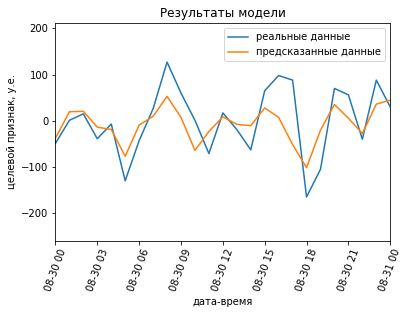

In [36]:
sns.lineplot(x=target_test.index,
                y=target_test,
                label='реальные данные')
sns.lineplot(x=target_test.index,
                y=target_predict_lgbm,
                label='предсказанные данные')
plt.legend(loc='upper right')
plt.title('Результаты модели')
plt.xlabel('дата-время')
plt.xticks(rotation=70)
plt.ylabel('целевой признак, у.е.')
plt.xlim(pd.Timestamp('2018-08-30'), pd.Timestamp('2018-08-31'))
plt.show()

**Вывод:** 
Из трех рассмотренных нами моделей наилучшие результаты показали `LGBMRegressor` и `CatBoostRegressor` с RMSE на тестовой выборке 42.45 и 42.93 соответственно.

Вернуться в [начало](#startpage).